In [ ]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
import numpy as np
import keras
from keras.callbacks import ModelCheckpoint
from keras import layers
from keras.layers import Dense, Flatten
from keras import activations
from keras.models import Sequential
from keras.models import Model
import sklearn
from keras.utils import np_utils
import dlib
from scipy.optimize import linear_sum_assignment
from keras import initializers

from joblib import Parallel, delayed
import random


In [ ]:
def hungarian(arr):
   row_ind, col_ind = linear_sum_assignment(arr)
   opt_cost = arr[row_ind, col_ind].sum()
   return row_ind,col_ind, opt_cost

def create_models(N, numberofneuron):
  models = []
  for i in range(N):
    model = Sequential()
    model.add(Dense(numberofneuron, activation='relu', input_shape=(28*28,)))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
    models.append(model)
  return models

def dataset_devision(x_train,y_train,datanumber):
  x_trains = []
  y_trains = []
  start = 0
  for n in datanumber:
    x_trains.append(x_train[start:start+n])
    y_trains.append(y_train[start:start+n])
    start += n
  return x_trains,y_trains

def train_model(Model, x_t, y_t):
  trainedModel = Model.fit(x_t, y_t, epochs=1, batch_size=10)
  return Model.get_weights()


def average_weights(weight_list, sample_sizes):
  averaged_weights = []
  for weights in zip(*weight_list):
    weighted_sum = 0
    total_samples = sum(sample_sizes)
    for i in range(len(weights)):
      weighted_sum += weights[i] * sample_sizes[i]
    averaged_weights.append(weighted_sum / total_samples)
  return averaged_weights

def classify_error(net_output, test_data, test_labels):
  preds = np.argmax(net_output, axis=1)
  true = test_labels
  diff = preds - true
  incorrect = np.nonzero(diff)[0]
  error_rate = len(incorrect) / 10000
  return error_rate





In [ ]:
from keras.datasets import mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28*28)  # Flatten the 28x28 images into 1D vectors
x_test = x_test.reshape(-1, 28*28)
y_train = to_categorical(y_train, 10)  # 10 classes for digits 0 to 9
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000,)


In [ ]:
datanumber=[100,200, 300, 400, 500, 400, 300, 200, 100, 200, 300, 400, 500, 600, 100, 200, 300, 400, 500, 100]
delay_req=0.5                 #delay requirement
energy_req=0.003              #energy requirement
total_user = 9
kk = 0
N  = 10 ** -20
user_Bw = 1 # MHz
bs_Bw = 20  # MHz
m = 1.08
user_P = 0.01
bs_P = 1
bs_I = 0.06 * 0.000003
averagenumber=3;              #Number of implementation of FL
cpu_freq = 10 ** 9
cpu_cycles = 40
energy_coeff = 10 ** (-27)
o = 1                         #Rayleigh fading parameter
usernumber = 15
numberofneuron = 50
iteration = 5

w_local = []                  # hidden layer weights
w_global = []                 # global hidden layer weights

active_users = np.zeros((iteration, usernumber))
error = np.zeros((iteration, 1))
iterationtime = np.zeros((iteration, 1))
x_trains,y_trains = dataset_devision(x_train,y_train,datanumber)


# baseline 0 : proposed algorithm
# baseline 1 : optimal user selection with random RB allocation
# baseline 2 : randome user selection with random RB allocation
# baseline 3 : minimize packet error rate without considering FL performance


In [ ]:
user_I = []
total_results = []
for baseline in [0,1,2,3]:
  print("baseline {} :".format(baseline))
  average_results = []

  for rbnum in [3, 6, 9, 12]:
    rbnum = 6
    kk += 1
    if rbnum == 3:
        user_I = (np.array([0.05, 0.1, 0.14]) - 0.04) * 0.000001

    elif rbnum == 6:
        user_I = (np.array([0.05, 0.07, 0.09, 0.11, 0.13, 0.15]) - 0.04) * 0.000001

    elif rbnum == 9:
        user_I = (np.array([0.03, 0.06, 0.07, 0.08, 0.1, 0.11, 0.12, 0.14, 0.15]) - 0.04) * 0.000001

    elif rbnum == 12:
        user_I = (np.array([0.03, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]) - 0.04) * 0.000001
    RBnumber = len(user_I)

    for average in range(averagenumber):
      print("\tImplementation {} :".format(average))
      test_loss     = []
      test_accuracy = []
      d = np.random.rand(usernumber, 1) * 500
      q = 1 - np.exp(-1.08 * (user_I + N*user_Bw) / (user_P * d**(-2)))
      h = o * (d ** (-2))

      user_SINR = user_P * h / (user_I + N*user_Bw)
      user_rate = user_Bw * np.log2(1 + user_SINR)

      bs_SINR = bs_P * h / (bs_I + N*bs_Bw)
      bs_rate = bs_Bw * np.log2(1 + bs_SINR)

      Z = 39760 * 16 / (1024 * 1024) #MBytes
      user_delay = Z / user_rate
      bs_delay = Z / bs_rate

      total_delay = user_delay + bs_delay
      total_energy = energy_coeff * cpu_cycles * (cpu_freq ** 2) * Z + user_P * user_delay

      if baseline == 0:
        W = np.zeros((usernumber, RBnumber))
        for i in range(usernumber):
          for j in range(RBnumber):
            if total_delay[i,j] < delay_req and total_energy[i,j] < energy_req:
              W[i,j] = datanumber[i] * (q[i,j] - 1)

        users, rbs, costs = hungarian(W)
        finalq = np.ones(usernumber)
        for i,j in zip(users,rbs):
            finalq[i] = q[i, j]

      elif baseline == 1:
        W = np.zeros((usernumber, RBnumber))
        for i in range(usernumber):
          for j in range(RBnumber):
            if total_delay[i,j] < delay_req and total_energy[i,j] < energy_req:
              W[i,j] = datanumber[i] * (q[i,j] - 1)

        users, rbs, costs = hungarian(W)
        finalq = np.ones(usernumber)
        for i,j in zip(users,random.sample(range(RBnumber), min(RBnumber,usernumber))):
            finalq[i] = q[i, j]

      elif baseline == 2:
        finalq = np.ones(usernumber)
        for i,j in zip(random.sample(range(usernumber), min(RBnumber,usernumber)),random.sample(range(RBnumber), min(RBnumber,usernumber))):
            finalq[i] = q[i, j]

      elif baseline == 3 :
        W = np.zeros((usernumber, RBnumber))
        for i in range(usernumber):
          for j in range(RBnumber):
            if total_delay[i,j] < delay_req and total_energy[i,j] < energy_req:
              W[i,j] = q[i,j]
        users, rbs, costs = hungarian(W)
        finalq = np.ones(usernumber)
        for i,j in zip(users,random.sample(range(RBnumber), min(RBnumber,usernumber))):
            finalq[i] = q[i, j]

      else:
        print("Base line you selected is Worng.")
        break
      models = create_models(usernumber, numberofneuron)
      FL_models = []
      X_trains = []
      Y_trains = []
      temp = []
      t = 0

      for i in range(usernumber):
        if finalq[i] != 1:
          FL_models.append(models[i])
          X_trains.append(x_trains[i])
          Y_trains.append(y_trains[i])
          temp.append(t)
          t = t + 1

      data_list = list(zip(FL_models, X_trains, Y_trains))

      for i in range(iteration):

        weights = Parallel(n_jobs=len(FL_models))(delayed(train_model)(model, x_train, y_train)for model, x_train, y_train in data_list)
        w_global = average_weights(weights,datanumber[0:len(weights)])

        for model in FL_models:
          model.set_weights(w_global)

        net_output = model.predict(x_test,verbose=0)
        error_rate = classify_error(net_output, x_test, y_test)
        accuracy = 1 - error_rate
        error_rate = np.round(error_rate,3)
        accuracy = np.round(accuracy,3)
        test_loss.append(error_rate)
        test_accuracy.append(accuracy)
        print("\t\tIteration {} --> test_loss: {}, test_accuracy: {}".format(i,error_rate, accuracy))
      average_results.append(test_accuracy)
    temp = [np.mean([i,j,k]) for i,j,k in zip(*average_results)]
    break
  total_results.append(temp)







baseline 0 :
	Implementation 0 :
		Iteration 0 --> test_loss: 0.818, test_accuracy: 0.182
		Iteration 1 --> test_loss: 0.723, test_accuracy: 0.277
		Iteration 2 --> test_loss: 0.444, test_accuracy: 0.556
		Iteration 3 --> test_loss: 0.319, test_accuracy: 0.681
		Iteration 4 --> test_loss: 0.256, test_accuracy: 0.744
	Implementation 1 :
		Iteration 0 --> test_loss: 0.717, test_accuracy: 0.283
		Iteration 1 --> test_loss: 0.677, test_accuracy: 0.323
		Iteration 2 --> test_loss: 0.457, test_accuracy: 0.543
		Iteration 3 --> test_loss: 0.318, test_accuracy: 0.682
		Iteration 4 --> test_loss: 0.212, test_accuracy: 0.788
	Implementation 2 :
		Iteration 0 --> test_loss: 0.808, test_accuracy: 0.192
		Iteration 1 --> test_loss: 0.714, test_accuracy: 0.286
		Iteration 2 --> test_loss: 0.408, test_accuracy: 0.592
		Iteration 3 --> test_loss: 0.312, test_accuracy: 0.688
		Iteration 4 --> test_loss: 0.27, test_accuracy: 0.73
baseline 1 :
	Implementation 0 :
		Iteration 0 --> test_loss: 0.726, test_

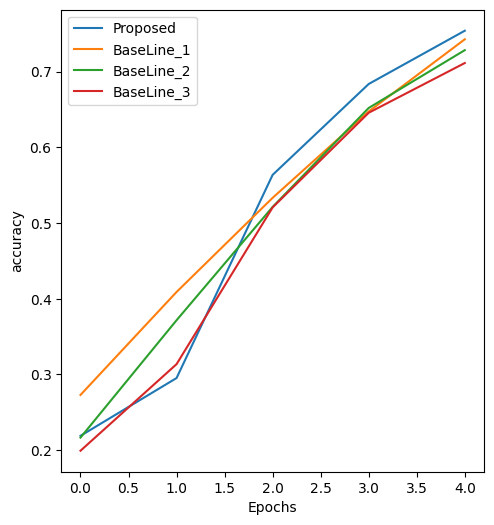

In [ ]:
plt.figure(figsize=(12,6))
# plt.subplot(121)
# plt.xlabel('Epochs')
# plt.ylabel('loss')
# plt.plot(test_loss)
# plt.legend(['loss'])
plt.subplot(122)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.plot(total_results[0])
plt.plot(total_results[1])
plt.plot(total_results[2])
plt.plot(total_results[3])
plt.legend(['Proposed','BaseLine_1','BaseLine_2','BaseLine_3'])